### Collision rate

In [8]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
from torch import nn
from mapsgan import BaseSolver, experiments, data_loader
from mapsgan import ToyGenerator, ToyDiscriminator, BicycleGenerator, norm_scene, cos_scene
from mapsgan.evaluation import Visualization
from sgan import TrajectoryDiscriminator, TrajectoryGenerator
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform, pdist
import os
model_path = '../models/cloud/'
os.listdir(model_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


['bicy_enc_1_20190117-134649_epoch_10000',
 'bicy_weights_1_20190117-155010_epoch_10000',
 'bicy_weights_2_20190118-073226_epoch_70000',
 'bicy_weights__encoptim_3_20190118-124310_epoch_10000',
 'clr_1_20190114-160949_epoch_10000',
 'cvae_1_20190114-154818_epoch_10000',
 'sgan_1_20190117-055507_epoch_10000',
 'toymodel_1_20190117-172104_epoch_10000']

In [9]:
in_len, out_len = 8, 12
sgangenerator = TrajectoryGenerator(obs_len=8,
                                pred_len=12,
                                embedding_dim=16,
                                encoder_h_dim=32,
                                decoder_h_dim=32,
                                mlp_dim=64,
                                num_layers=1,
                                noise_dim=(8,),
                                noise_type='gaussian',
                                noise_mix_type='global',
                                pooling_type='pool_net',
                                pool_every_timestep=1,
                                dropout=0,
                                bottleneck_dim=32,
                                neighborhood_size=2,
                                grid_size=8,
                                batch_norm=0)

toygenerator = ToyGenerator(in_len=in_len, out_len=out_len)
toydiscriminator = ToyDiscriminator()

bicyclegenerator = BicycleGenerator(ToyGenerator, start_mode='cvae')

In [10]:
models = {'Baseline':{'generator': toygenerator, 'ckpt': 'toymodel_1_20190117-172104_epoch_10000'},
          'cLR':{'generator': bicyclegenerator, 'ckpt': 'clr_1_20190114-160949_epoch_10000'},
          'cVAE':{'generator': bicyclegenerator, 'ckpt': 'cvae_1_20190114-154818_epoch_10000'},
          'Bicycle':{'generator': bicyclegenerator, 'ckpt': 'bicy_weights_1_20190117-155010_epoch_10000'},
          'SGAN':{'generator': sgangenerator, 'ckpt': 'sgan_1_20190117-055507_epoch_10000'},
          'cLRSGAN':{'generator': None, 'ckpt': ''},
          'cVAESGAN':{'generator': None, 'ckpt': ''},
          'BicycleSGAN':{'generator': None, 'ckpt': ''}}

In [11]:
def get_model_solver(key, models, solver=BaseSolver):
    solver = solver(ToyGenerator(in_len=in_len, out_len=out_len), ToyDiscriminator()) # dummies
    solver.generator = models[key]['generator']
    solver.load_generator(model_path + models[key]['ckpt'])
    return solver

In [99]:
solver = get_model_solver('cLR', models)

In [63]:
experiment = experiments.ETH() # we store filepaths and arguments in here
dataset, testloader = data_loader(in_len=8,
                                   out_len=12,
                                   batch_size=64,
                                   num_workers=1,
                                   path=experiment.test_dir,
                                   shuffle=False)

In [100]:
output = solver.test(testloader)

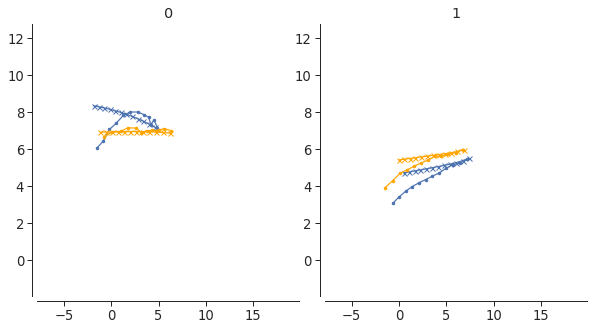

In [79]:
vis = Visualization()
vis.trajectories(output, [0, 1], ground_truth=True, )

In [81]:
output['xy_pred'][0]

array([[[ 4.605405  ,  7.177414  ],
        [ 6.160743  ,  6.8594174 ]],

       [[ 3.9975758 ,  7.349273  ],
        [ 5.430111  ,  6.8937807 ]],

       [[ 3.3885226 ,  7.504848  ],
        [ 4.707678  ,  6.9192944 ]],

       [[ 2.784983  ,  7.6443157 ],
        [ 4.00394   ,  6.935646  ]],

       [[ 2.1870327 ,  7.7684207 ],
        [ 3.315872  ,  6.9435062 ]],

       [[ 1.5938473 ,  7.8789783 ],
        [ 2.6410756 ,  6.945406  ]],

       [[ 1.0053434 ,  7.978046  ],
        [ 1.9791417 ,  6.943056  ]],

       [[ 0.42179203,  8.067234  ],
        [ 1.3299999 ,  6.9376435 ]],

       [[-0.15691614,  8.147605  ],
        [ 0.69301844,  6.9299345 ]],

       [[-0.7299199 ,  8.21937   ],
        [ 0.06694698,  6.9216404 ]],

       [[-1.2965789 ,  8.282887  ],
        [-0.5483613 ,  6.913644  ]],

       [[-1.8563094 ,  8.338187  ],
        [-1.1530848 ,  6.9061584 ]]], dtype=float32)

### Collision rate

In [42]:
def get_collisions(xy, thresh=0.5):
    """Computes collision on array of (seq_len, num_agents, num_chords)"""
    from scipy.spatial.distance import pdist, squareform
    collisions = 0
    for i, step in enumerate(xy):
        dm = squareform(pdist(step))  # step is (num_agents, dimensions xy) 
        ind = np.triu_indices(dm.shape[0], k=1)
        for distance in dm[ind]:
            if distance < thresh:
                collisions += 1
    return collisions

def get_all_collisions(xy_pred, thresh=0.5):
    """Computes collisions for all scenes."""
    collisions = 0
    for scene in xy_pred:
        collisions += get_collisions(scene, thresh)
    return collisions

In [45]:
get_all_collisions(output['xy_pred'], thresh=0.5)

48

### Final displacement error

In [101]:
pred = output['xy_pred']
gt = output['xy_out']

In [102]:
def average_fde(output):
    pred = output['xy_pred']
    gt = output['xy_out']
    diff = 0
    for i, scene in enumerate(pred):
        last_p = scene[-1]
        last_gt = gt[i][-1]
        diff += np.linalg.norm((last_p-last_gt), axis=1).mean()
    diff /= len(pred)
    return diff
    

In [103]:
average_fde(output)

35.91936370304653